In [20]:
!pip install transformers torch nltk scikit-learn sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 9.7 MB/s eta 0:00:00


In [21]:
import requests
from bs4 import BeautifulSoup
import re
from pydantic import BaseModel
import torch
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, BertModel
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
import nltk
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Task 1: Extracting text from patents
**Goal:** Get claims from three patents related to mobile communications.

In [7]:
url = 'https://patents.google.com/patent/GB2478972A/en?q=(phone)&oq=phone'

response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# search for all elements in claim class
claims_divs = soup.find_all('div', {'class': 'claim'})
claims_list = [claim.get_text(strip=True) for claim in claims_divs]

if claims_list[0].startswith('CLAIMS'):
    claims_list[0] = claims_list[0].replace('CLAIMS', '', 1).strip()

for i, claim in enumerate(claims_list, 1):
    print(f"Claim {i}: {claim}")

Claim 1: 1. A wireless telephone apparatus comprising: a handset; an onioff-hook switch; a wireless communications module for establishing first and second cellular telephone calls via a base station; and means for generating an explicit call transfer command for sending to the base station in response to activation of the on-hook switch when the first and second wireless calls are established through the apparatus.
Claim 2: 2. The apparatus of claim 1, ftirther comprising a body having a cradle for the handset, wherein the onloff hook switch operates in response to placing the handset in the cradle.
Claim 3: 3. The apparatus of claim 1, 2 or 3, ftirther comprising: call receiving means for receiving a first call from a calling party; call initiating means for entering a call initiation mode, in response to activation of a first predetermined button, for initiating a second call; and transfer means for putting the first call on hold, initiating the second call, and toggling, in respons

# Task 2: Grouping claims by topic
**Goal:** Use different models to group claims by similar topics.

## Part 1 - Data Processing

In [8]:
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def remove_stopwords(claim):
    words = word_tokenize(claim)
    cleaned_claim = ' '.join([word for word in words if word.lower() not in stop_words])
    return cleaned_claim

def preprocess_claim(claim):
    words = word_tokenize(claim)
    final_claims = ' '.join([stemmer.stem(word) for word in words if word.lower() not in stop_words])
    return final_claims

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [24]:

cleaned_claims = [remove_stopwords(claim) for claim in claims_list]
final_claims = [preprocess_claim(claim) for claim in cleaned_claims]

model = SentenceTransformer('all-MiniLM-L6-v2')  # מודל SBERT קטן אך יעיל
embeddings = model.encode(final_claims)

In [25]:
print(embeddings.shape)
print(embeddings)

(14, 384)
[[-0.07511535  0.03432142 -0.02507699 ...  0.10909706  0.00339466
  -0.05493566]
 [-0.09807663  0.01779355 -0.03285895 ...  0.07619638 -0.03417628
   0.03860396]
 [-0.12269697 -0.01643683 -0.04183333 ...  0.0805323  -0.01296195
  -0.00993752]
 ...
 [-0.07757819  0.03673599 -0.06605016 ...  0.09344505 -0.03185125
   0.01464828]
 [-0.08995003  0.04805566  0.00915374 ...  0.12761354 -0.03210777
  -0.05570037]
 [-0.03408807  0.03330678  0.02305299 ...  0.05665413 -0.06527311
  -0.01831178]]


## Part 2 - Applying the Clustering Algorithms

### K-Means Clustering

In [36]:
num_clusters = 4

# Apply K-Means clustering to the embeddings
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embeddings)

# Get the cluster labels assigned to each claim
kmeans_labels = kmeans.labels_

# Print the cluster each claim belongs to
for i, claim in enumerate(claims_list):
    print(f"Claim {i+1}: Cluster {kmeans_labels[i]}")

Claim 1: Cluster 0
Claim 2: Cluster 1
Claim 3: Cluster 1
Claim 4: Cluster 2
Claim 5: Cluster 1
Claim 6: Cluster 1
Claim 7: Cluster 2
Claim 8: Cluster 3
Claim 9: Cluster 3
Claim 10: Cluster 3
Claim 11: Cluster 2
Claim 12: Cluster 2
Claim 13: Cluster 0
Claim 14: Cluster 3


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### DBSCAN

In [28]:
# Apply DBSCAN clustering to the embeddings
dbscan = DBSCAN(eps=0.2, min_samples=2, metric='cosine')
dbscan_labels = dbscan.fit_predict(embeddings)

# Print the cluster each claim belongs to
for i, claim in enumerate(claims_list):
    print(f"Claim {i+1}: Cluster {dbscan_labels[i]}")

Claim 1: Cluster 0
Claim 2: Cluster -1
Claim 3: Cluster 1
Claim 4: Cluster 2
Claim 5: Cluster 1
Claim 6: Cluster -1
Claim 7: Cluster -1
Claim 8: Cluster -1
Claim 9: Cluster -1
Claim 10: Cluster -1
Claim 11: Cluster 2
Claim 12: Cluster 2
Claim 13: Cluster 0
Claim 14: Cluster -1


### Agglomerative Clustering

In [37]:
num_clusters = 4

# Apply Agglomerative Clustering to the embeddings
agglo = AgglomerativeClustering(n_clusters=num_clusters, affinity='cosine', linkage='average')
agglo_labels = agglo.fit_predict(embeddings)

# Print the cluster each claim belongs to
for i, claim in enumerate(claims_list):
    print(f"Claim {i+1}: Cluster {agglo_labels[i]}")

Claim 1: Cluster 0
Claim 2: Cluster 0
Claim 3: Cluster 2
Claim 4: Cluster 2
Claim 5: Cluster 2
Claim 6: Cluster 2
Claim 7: Cluster 2
Claim 8: Cluster 1
Claim 9: Cluster 1
Claim 10: Cluster 1
Claim 11: Cluster 2
Claim 12: Cluster 2
Claim 13: Cluster 0
Claim 14: Cluster 3


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Final Results

In [38]:

def group_claims_by_cluster(claims, labels):
    clusters = {}
    for label, claim in zip(labels, claims):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(claim)
    return clusters

# Grouping by each algorithm's labels
kmeans_clusters = group_claims_by_cluster(claims_list, kmeans_labels)
dbscan_clusters = group_claims_by_cluster(claims_list, dbscan_labels)
agglo_clusters = group_claims_by_cluster(claims_list, agglo_labels)

## Part 3 - Generate Topics

In [43]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Generate titles for each cluster using LDA

def generate_topics_for_clusters(clusters, num_topics=1):
    vectorizer = CountVectorizer(stop_words='english')
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)

    cluster_topics = {}
    for cluster_id, cluster_claims in clusters.items():
        if len(cluster_claims) > 0:
            X = vectorizer.fit_transform(cluster_claims)
            lda.fit(X)
            words = vectorizer.get_feature_names_out()
            topic_words = [words[i] for i in lda.components_[0].argsort()[-2:]]
            cluster_topics[cluster_id] = " ".join(topic_words)
        else:
            cluster_topics[cluster_id] = "No sufficient data"

    return cluster_topics

# Generate topics for each clustering method
kmeans_topics = generate_topics_for_clusters(kmeans_clusters)
dbscan_topics = generate_topics_for_clusters(dbscan_clusters)
agglo_topics = generate_topics_for_clusters(agglo_clusters)

print("K-Means Topics:", kmeans_topics)
print("DBSCAN Topics:", dbscan_topics)
print("Agglomerative Clustering Topics:", agglo_topics)

K-Means Topics: {0: 'telephone wireless', 1: 'means second', 2: 'predetermined button', 3: 'second means'}
DBSCAN Topics: {0: 'telephone wireless', -1: 'means apparatus', 1: 'means second', 2: 'predetermined button'}
Agglomerative Clustering Topics: {0: 'apparatus wireless', 2: 'second button', 1: 'second means', 3: 'reference substantially'}


## Comparison

1. Silhouette Score: The Silhouette Score measures how similar each point is to others in its own cluster compared to points in other clusters. It ranges between -1 and 1.

2. Davies-Bouldin Index (DBI): The DBI measures the ratio of the within-cluster distances to the between-cluster distances. It ranges from 0 to ∞, where lower values indicate better clustering.

3. Calinski-Harabasz Index (CH): The CH Index measures the ratio of the sum of between-cluster dispersion to the within-cluster dispersion. Higher values indicate better-defined clusters.

**Summary:**

Silhouette Score: The higher, the better, ideally above 0.5.

Davies-Bouldin Index: The lower, the better, ideally below 1.

Calinski-Harabasz Index: The higher, the better.

In [40]:
# Numeric measures
def calculate_metrics(embeddings, labels):
    silhouette_avg = silhouette_score(embeddings, labels)
    dbi_score = davies_bouldin_score(embeddings, labels)
    ch_score = calinski_harabasz_score(embeddings, labels)
    return silhouette_avg, dbi_score, ch_score

kmeans_silhouette, kmeans_dbi, kmeans_ch = calculate_metrics(embeddings, kmeans_labels)
print(f"K-Means Metrics:\nSilhouette Score: {kmeans_silhouette}\nDavies-Bouldin Index: {kmeans_dbi}\nCalinski-Harabasz Index: {kmeans_ch}\n")

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette, dbscan_dbi, dbscan_ch = calculate_metrics(embeddings, dbscan_labels)
    print(f"DBSCAN Metrics:\nSilhouette Score: {dbscan_silhouette}\nDavies-Bouldin Index: {dbscan_dbi}\nCalinski-Harabasz Index: {dbscan_ch}\n")
else:
    print("DBSCAN did not find enough clusters to calculate the metrics.\n")

agglo_silhouette, agglo_dbi, agglo_ch = calculate_metrics(embeddings, agglo_labels)
print(f"Agglomerative Clustering Metrics:\nSilhouette Score: {agglo_silhouette}\nDavies-Bouldin Index: {agglo_dbi}\nCalinski-Harabasz Index: {agglo_ch}\n")


K-Means Metrics:
Silhouette Score: 0.18225789070129395
Davies-Bouldin Index: 1.4327684757963415
Calinski-Harabasz Index: 3.434321094383583

DBSCAN Metrics:
Silhouette Score: 0.1381305456161499
Davies-Bouldin Index: 1.4084453920819167
Calinski-Harabasz Index: 2.63892889531642

Agglomerative Clustering Metrics:
Silhouette Score: 0.1628669798374176
Davies-Bouldin Index: 1.2152657788257255
Calinski-Harabasz Index: 3.0691360117822093



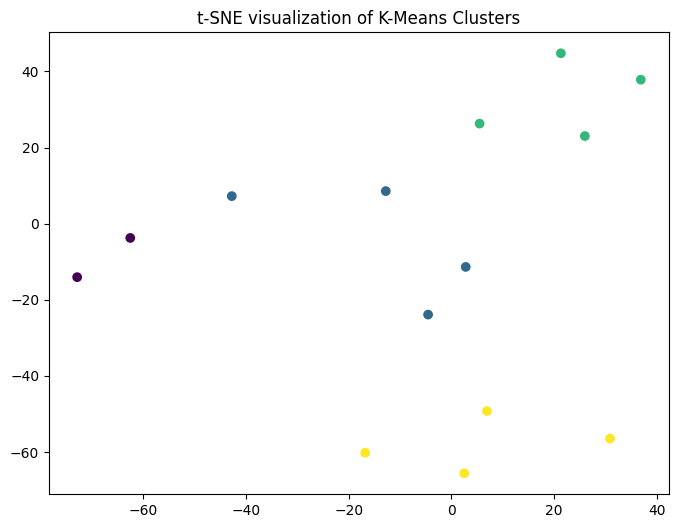

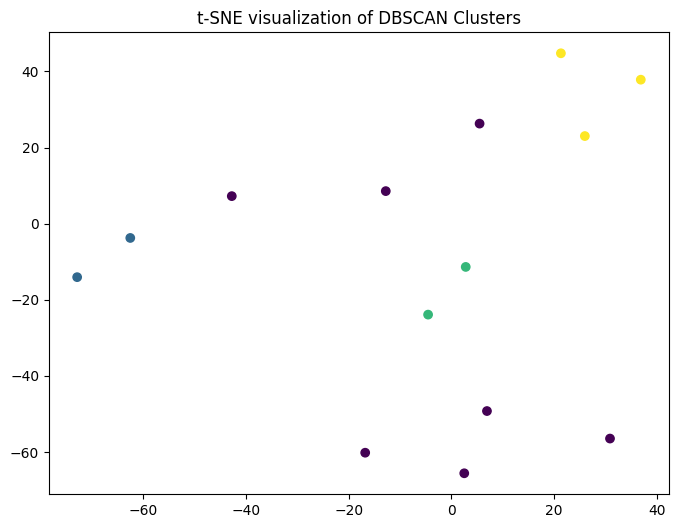

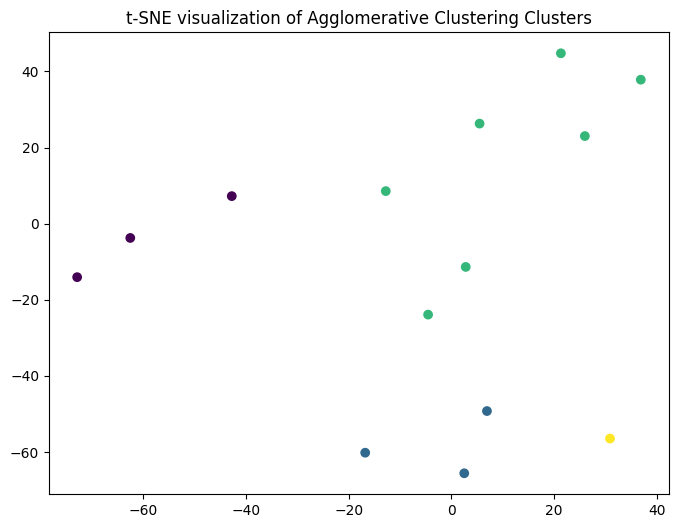

In [42]:
# Visualize

def plot_tsne(embeddings, labels, title, perplexity=5):
    tsne = TSNE(n_components=2, perplexity=perplexity,  random_state=42)
    tsne_results = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis')
    plt.title(title)
    plt.show()

plot_tsne(embeddings, kmeans_labels, "t-SNE visualization of K-Means Clusters")

if len(set(dbscan_labels)) > 1:
    plot_tsne(embeddings, dbscan_labels, "t-SNE visualization of DBSCAN Clusters")

plot_tsne(embeddings, agglo_labels, "t-SNE visualization of Agglomerative Clustering Clusters")


### **Model Selection Explanation:**

Based on the clustering metrics, **K-Means** appears to be the preferred model for this task. It achieved a higher Silhouette Score and a higher Calinski-Harabasz Index compared to the other models, indicating that the clusters formed by K-Means are more distinct and well-separated. While Agglomerative Clustering demonstrated more compact clusters with a lower Davies-Bouldin Index, the overall separation between clusters was less clear. Additionally, the visual representation of the clusters generated by K-Means further supports its superiority, as the clusters appear more defined and better organized.

# Task 3: Creating an interactive application

> *In the app.py file*

